In [127]:
import ee 
import geemap
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Create a map centred at (lat, lon).
Map = geemap.Map(center=[40, -100], zoom=4)

In [33]:
# Display the map.
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [34]:
#define the regions we're interested in, and also access landcover information derived from MODIS

haiti_region = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
  .filter(ee.Filter.eq('country_na', 'Haiti'))

dr_region = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
  .filter(ee.Filter.eq('country_na', 'Dominican Republic'))

# Load MODIS land cover categories in 2001.
landcover = ee.ImageCollection('MODIS/006/MCD12Q1') \
  .select('LC_Type1')

In [35]:
#define a colour palette to view landcover data. View all on the map above

igbpLandCoverVis = {
  'min': 1.0,
  'max': 17.0,
  'palette': [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff'
  ]
}
    
Map.addLayer(landcover, igbpLandCoverVis, 'landcover')
Map.addLayer(haiti_region, {'color':'red'}, 'haiti_region')
Map.addLayer(dr_region, {'color':'blue'}, 'dr_region')

In [184]:
class_images = landcover.select('LC_Type1') #select the landcover band where an integer represents the class
 #(see https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1#description)

#empty list to store data
data = []

#go through 19 years of data
N = 19
for i in range(N):
    #access a particular year in the collection of images
    class_image = ee.Image(class_images.toList(class_images.size()).get(i))
    
    #empty array to store data
    year_data = np.zeros(18)

    #print year of image
    print(class_image.get('system:index').getInfo())
    
    #get area of pixels as a band, perform a reduction so we get the number of pixels for each class for the 
    #particular year
    image = ee.Image.pixelArea().addBands(class_image)
    sums = image.reduceRegion(**{
          'reducer': ee.Reducer.sum().group(**{
            'groupField': 1,
            'groupName': 'code',
          }),
          'geometry': haiti_region.geometry(),
          'scale': 500,
          'maxPixels': 1e8
        })
  
    #messy way of sorting the dictionary into a nicer structure
    class_year_data = sums.getInfo().get('groups')
    for class_type in class_year_data:
        year_data[class_type['code']] = class_type['sum']
                  
    data.append(year_data)

2001_01_01
2002_01_01
2003_01_01
2004_01_01
2005_01_01
2006_01_01
2007_01_01
2008_01_01
2009_01_01
2010_01_01
2011_01_01
2012_01_01
2013_01_01
2014_01_01
2015_01_01
2016_01_01
2017_01_01
2018_01_01
2019_01_01


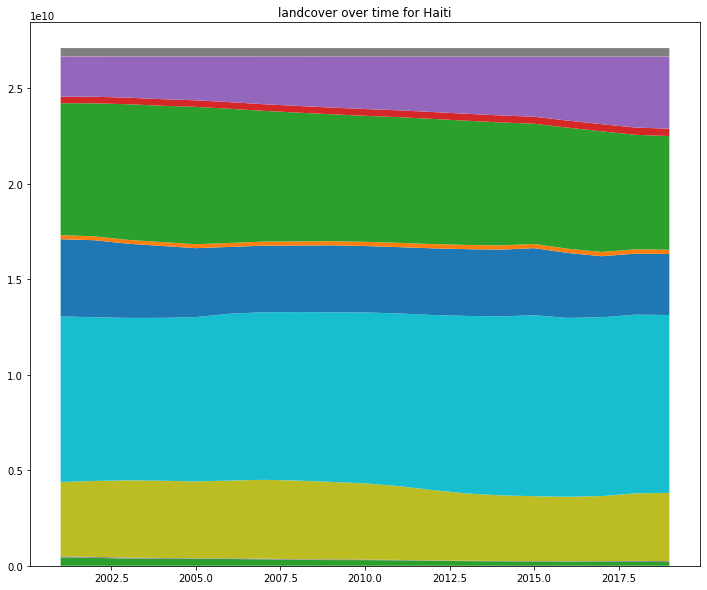

In [185]:
#make a stack plot to show lc over time

plt.figure(figsize=(12,10))
plt.title('landcover over time for Haiti')
plt.stackplot(list(range(2001,2001+N)),np.vstack(np.array(data).T))